# On Analyzing Real World Time Series for Forecasting Stock Data - Google Returns Data

- TUTORIAL: [Guide to Time Series Analysis with Python — 1: Analysis Techniques and Baseline Model](https://buse-koseoglu13.medium.com/guide-to-time-series-analysis-with-python-1-analysis-techniques-and-baseline-model-59e12fdd2eba)
- CODE: [google_closing_article_1.ipynb](https://github.com/busekoseoglu/time-series-forecasting/blob/main/google_closing_article_1.ipynb)
- With splitting data
- **READ**: Reproducing all results except for `MSE` as we differ on what to pass into MSE function. The params that I'm passing references how Jason Brownlee uses `MSE` in [Random Walk for TSF with Python](https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/)

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

from collections import namedtuple
from data_loader import build_stock_uts
from ts_models import Model, RandomWalk, PersistenceWalkForward, AR, MA, ARMA, EvaluationMetric
from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Stock Data Analysis

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data
11. Split Returns Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
24. Follow-up

### Load Raw Data

In [2]:
start_date, end_date = "2022-06-22", "2023-06-22"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("GOOGL", "Google"),
    ("INTC", "Intel")
]
independent_variable = "Close"
# frequency = 
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=start_date, end_date=end_date, frequency='1d') for s in stocks}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

In [4]:
stock_symbol = 'GOOGL'
type(stocks[stock_symbol]), stocks[stock_symbol]

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Close))

In [5]:
stock_series = stocks[stock_symbol].get_series()
stock_series

array([111.48750305, 112.24199677, 117.97499847, 115.83350372,
       112.00749969, 111.70149994, 108.96299744, 108.73750305,
       113.26300049, 114.5719986 , 118.78299713, 119.35350037,
       115.67649841, 114.02050018, 111.35350037, 110.36750031,
       111.77749634, 109.02999878, 113.80999756, 113.90000153,
       114.33999634, 107.90000153, 107.51000214, 105.01999664,
       113.05999756, 114.22000122, 116.31999969, 114.86000061,
       115.12999725, 118.08000183, 118.19000244, 117.47000122,
       117.30000305, 116.62999725, 119.69999695, 118.83999634,
       121.68000031, 122.08000183, 121.69999695, 119.55000305,
       120.16999817, 117.20999908, 114.23999786, 113.86000061,
       113.69000244, 116.65000153, 110.33999634, 109.41999817,
       108.94000244, 108.22000122, 109.73999786, 107.84999847,
       106.80999756, 109.44999695, 108.37999725, 110.65000153,
       110.86000061, 104.31999969, 105.        , 102.91000366,
       102.80000305, 103.06999969, 101.13999939,  99.27

In [6]:
stock_df = stocks[stock_symbol].get_as_df()
stock_df

,Close
Date,
2022-06-22,111.487503
2022-06-23,112.241997
2022-06-24,117.974998
2022-06-27,115.833504
2022-06-28,112.007500
...,...
2023-06-14,123.669998
2023-06-15,125.089996
2023-06-16,123.529999


### Plot Raw Data

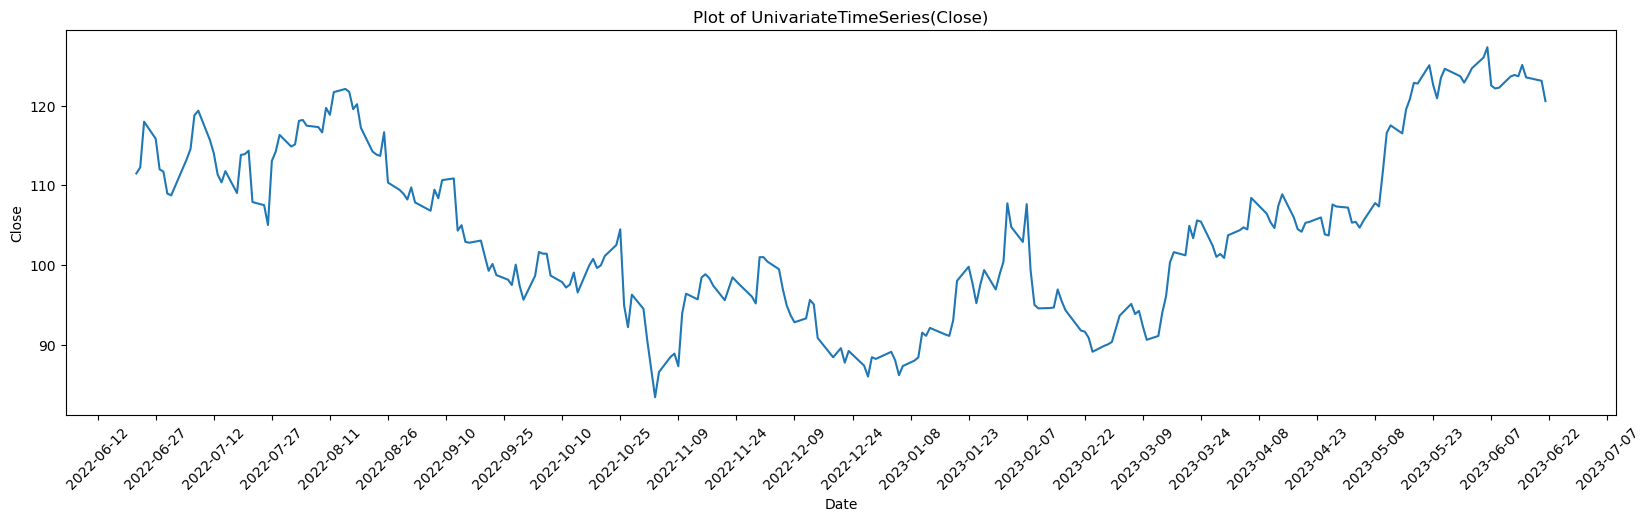

In [7]:
stocks[stock_symbol].plot(tick_skip=15)

- Google experienced a short decline from ~2022-08-11 to 2022-10-25, then an increase from 2022-10-25 to 2023-07-07. There exists several other changepoints, abeit small.

### Get Descriptive Statistics of Raw Data

In [8]:
stocks[stock_symbol].get_statistics()

,Close
count,251.000000
mean,104.054201
std,10.819246
min,83.430000
25%,95.555000
50%,102.900002
75%,111.892498
max,127.309998


In [9]:
stocks[stock_symbol].max_min_range()

{'Max': Close    127.309998
 dtype: float64,
 'Min': Close    83.43
 dtype: float64,
 'Range': Close    43.879997
 dtype: float64}

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary.
    - Can we verify this non-stationary with plotting the Autocorrelation?

In [10]:
stocks[stock_symbol].stationarity_test(stock_df)

ADF Statistic: -1.490478
p-value: 0.538216 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


### Plot Autocorrelation and Partial Autocorrelation of Raw Data

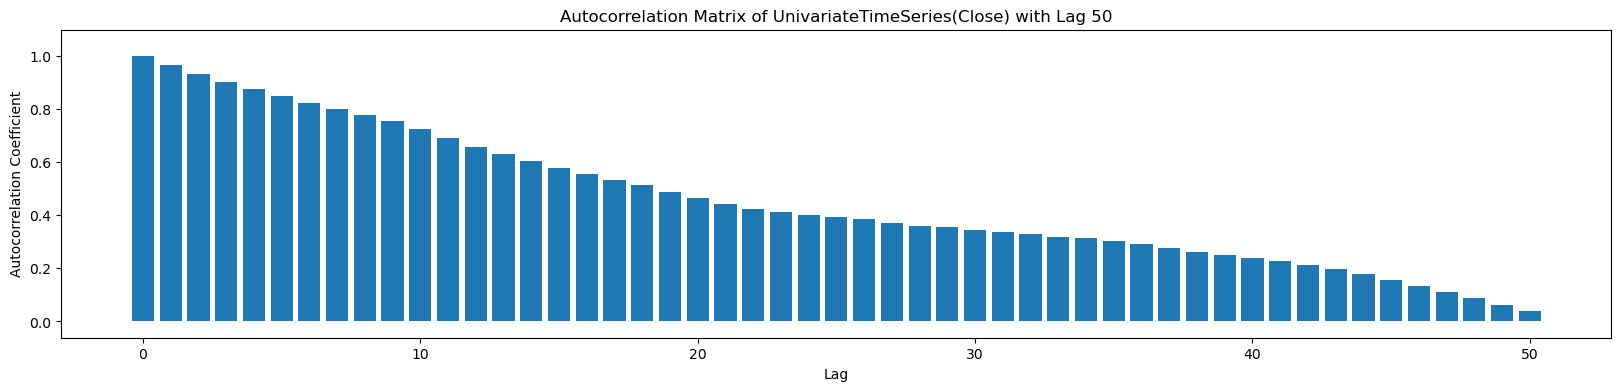

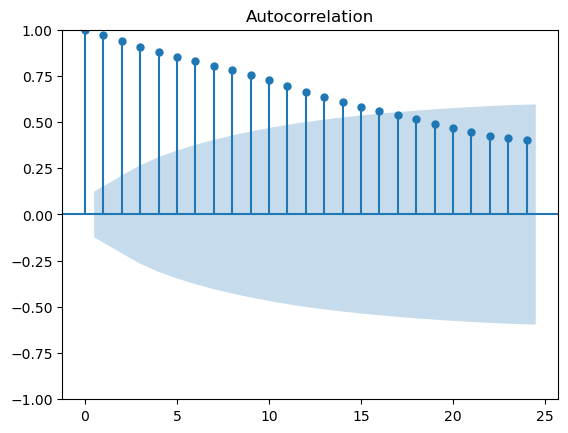

In [11]:
stocks[stock_symbol].plot_autocorrelation(50)

- Above, the data is highly correlated which means that the the current observation(1st with ACorr = 0) has some relationship (or dependence) k-th lag observation.
- In the TUTURIAL, Buse states, "In the presence of a trend, the ACF plot shows that the coefficients are high for the initial lags and decrease linearly as the lag increases."

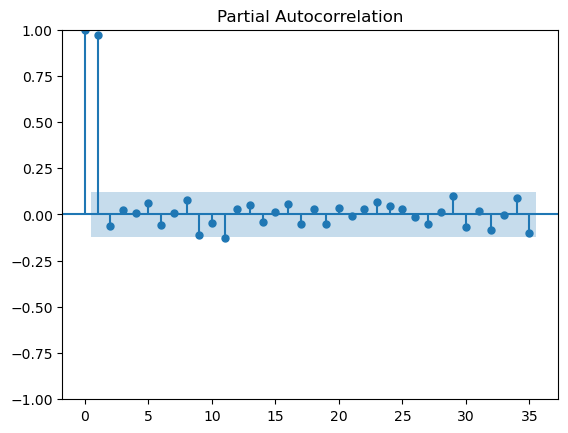

In [12]:
stocks[stock_symbol].plot_partial_autocorrelation(35)

- Above, the data shows a rapid decay at lag 2. 

### Get Returns Data

- Forecast returns
- Why: To have more stationarity (for the returns) compared to the prices `Open`/`Close` which is non-stationary
- Calculate with the `change` between $ z_t $ and $ z_{t-1} $
$$ Change = ((z_t - z_{t-1}) \div | z_{t-1} |) \space \rightarrow decimal \space form $$
$$ Percent \space Change = Change \times 100 \space \rightarrow pecent \space form $$
    - If `change` < 0, then stock price is going down, hence a **loss** from $ z_{t-1} \rightarrow z_t $
    - If `change` > 0, then stock price is going up, hence a **gain** from $ z_{t-1} \rightarrow z_t $
    - If `change` = 0, then stock price is constant, hence a **no loss nor no gain** from $ z_{t-1} \rightarrow z_t $
- NOTE: Shift the date by 1 because we don't have anything to subtract the 0th date by.

In [13]:
stock_returns = stocks[stock_symbol].data_augment_with_differencing(1)
stock_returns

UnivariateTimeSeries(Order-1 Difference of Close)

In [14]:
stock_returns_df = stock_returns.get_as_df()
stock_returns_df

,Order-1 Difference of Close
Date,
2022-06-23,0.754494
2022-06-24,5.733002
2022-06-27,-2.141495
2022-06-28,-3.826004
2022-06-29,-0.306000
...,...
2023-06-14,-0.160004
2023-06-15,1.419998
2023-06-16,-1.559998


### Plot Returns Data

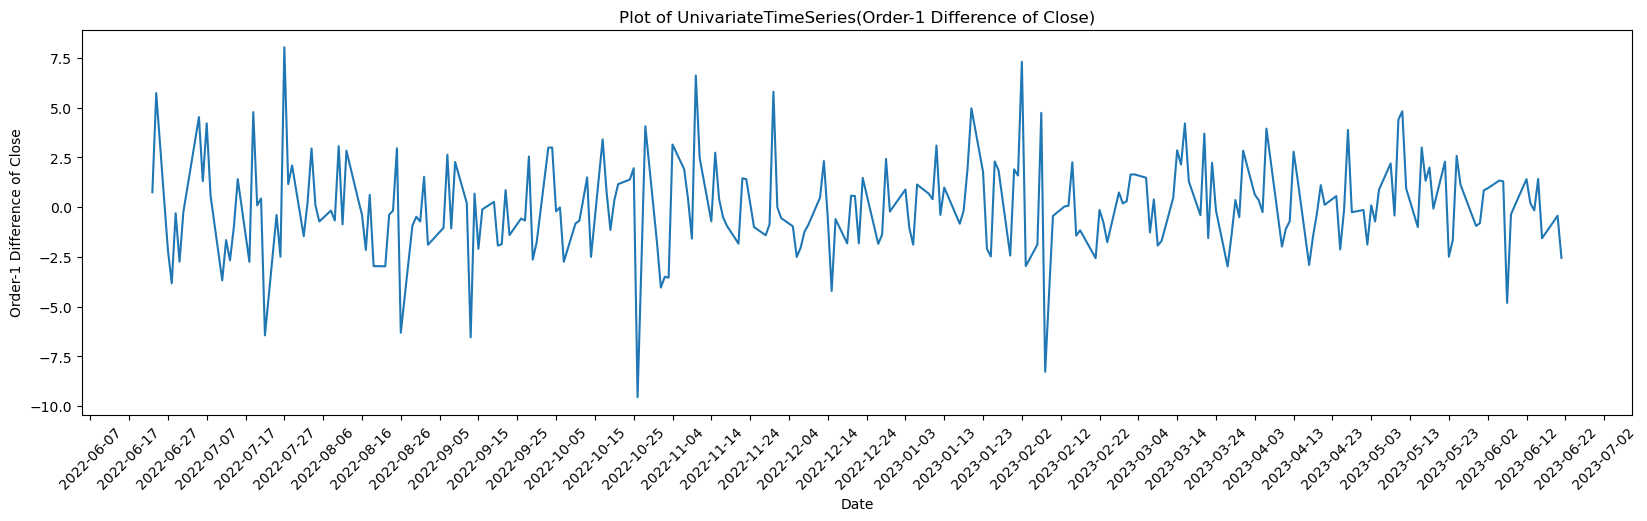

In [15]:
stock_returns.plot(tick_skip=10)

- Returns seem to have constant mean and constant variance although there are larger increases in 2022-07-17 to 2022-07-27, 2022-10-25, 2022-02-02, etc.

### Get Descriptive Statistics of Returns Data

In [16]:
stock_returns.get_statistics()

,Order-1 Difference of Close
count,250.000000
mean,0.036250
std,2.398035
min,-9.550003
25%,-1.424999
50%,-0.139999
75%,1.409996
max,8.040001


### Check Stationarity of Returns Data

In [17]:
stock_returns.stationarity_test(stock_returns_df)

ADF Statistic: -15.356126
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the TS is stationary
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


### Plot Autocorrelation and Partial Autocorrelation of Returns Data

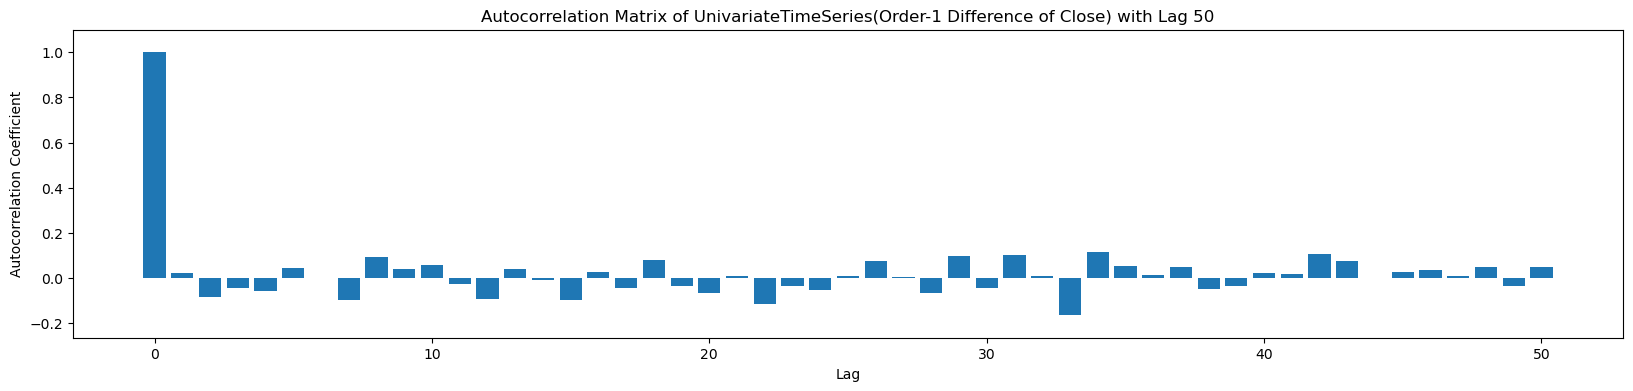

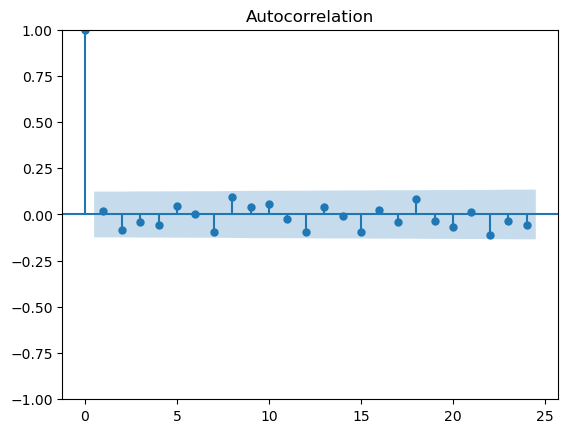

In [18]:
stock_returns.plot_autocorrelation(50)

- The ACorr rapidly decays as lag observation 1, so if we use an MA, we'd go with MA(1).

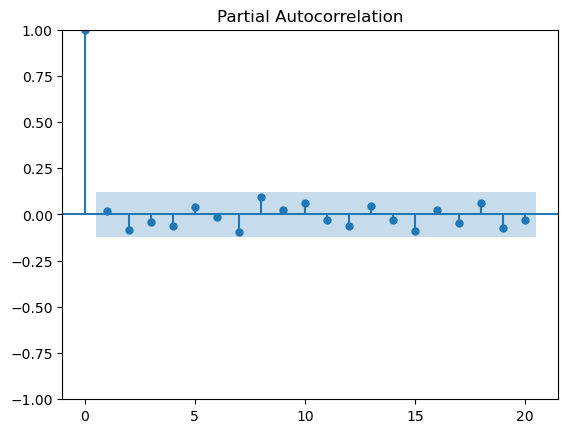

In [19]:
stock_returns.plot_partial_autocorrelation(20)

- The Partial ACorr rapidly decays as lag observation 1, so if we use an AR, we'd go with AR(1).

### Split Returns Data

In [20]:
df = stock_returns.get_as_df()
df

,Order-1 Difference of Close
Date,
2022-06-23,0.754494
2022-06-24,5.733002
2022-06-27,-2.141495
2022-06-28,-3.826004
2022-06-29,-0.306000
...,...
2023-06-14,-0.160004
2023-06-15,1.419998
2023-06-16,-1.559998


In [21]:
df["Close"] = df.iloc[0:]

In [22]:
stock_returns2 = df.drop(columns=['Order-1 Difference of Close'])
stock_returns2

,Close
Date,
2022-06-23,0.754494
2022-06-24,5.733002
2022-06-27,-2.141495
2022-06-28,-3.826004
2022-06-29,-0.306000
...,...
2023-06-14,-0.160004
2023-06-15,1.419998
2023-06-16,-1.559998


In [23]:
# train = df_[:246]
# test = df_[246:]

train = stock_returns2[:246]
train

,Close
Date,
2022-06-23,0.754494
2022-06-24,5.733002
2022-06-27,-2.141495
2022-06-28,-3.826004
2022-06-29,-0.306000
...,...
2023-06-08,-0.360001
2023-06-09,0.090004
2023-06-12,1.409996


In [24]:
train.values

array([[ 0.75449371],
       [ 5.73300171],
       [-2.14149475],
       [-3.82600403],
       [-0.30599976],
       [-2.7385025 ],
       [-0.22549438],
       [ 4.52549744],
       [ 1.30899811],
       [ 4.21099854],
       [ 0.57050323],
       [-3.67700195],
       [-1.65599823],
       [-2.66699982],
       [-0.98600006],
       [ 1.40999603],
       [-2.74749756],
       [ 4.77999878],
       [ 0.09000397],
       [ 0.43999481],
       [-6.43999481],
       [-0.38999939],
       [-2.49000549],
       [ 8.04000092],
       [ 1.16000366],
       [ 2.09999847],
       [-1.45999908],
       [ 0.26999664],
       [ 2.95000458],
       [ 0.11000061],
       [-0.72000122],
       [-0.16999817],
       [-0.6700058 ],
       [ 3.06999969],
       [-0.86000061],
       [ 2.84000397],
       [ 0.40000153],
       [-0.38000488],
       [-2.1499939 ],
       [ 0.61999512],
       [-2.95999908],
       [-2.97000122],
       [-0.37999725],
       [-0.16999817],
       [ 2.95999908],
       [-6

In [25]:
test = stock_returns2[246:]
test

,Close
Date,
2023-06-15,1.419998
2023-06-16,-1.559998
2023-06-20,-0.430000
2023-06-21,-2.549995


### Initialize Random Walk Model

In [27]:
import numpy as np
# Forecast with mean
coln = "Order-1 Difference of Close"
mean = np.mean(train.Close)

test.loc[:, "pred_mean"] = mean

# Forecast with last observed value

last_value = train.iloc[-1].Close
test.loc[:, "pred_last"] = last_value

/var/folders/fz/zn5r8vq12nv5p23dtlr15sk40000gn/T/ipykernel_48307/1169672285.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, "pred_mean"] = mean
/var/folders/fz/zn5r8vq12nv5p23dtlr15sk40000gn/T/ipykernel_48307/1169672285.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, "pred_last"] = last_value


In [28]:
rw_model_class = RandomWalk()
rw_model_class

RandomWalk()

In [29]:
test

,Close,pred_mean,pred_last
Date,,,
2023-06-15,1.419998,0.049522,-0.160004
2023-06-16,-1.559998,0.049522,-0.160004
2023-06-20,-0.430000,0.049522,-0.160004
2023-06-21,-2.549995,0.049522,-0.160004


In [30]:
rw_predictions = rw_model_class.predict(train.values, test.values)
rw_predictions

[array([-0.16000366]),
 array([ 1.41999817,  0.04952234, -0.16000366]),
 array([-1.55999756,  0.04952234, -0.16000366]),
 array([-0.43000031,  0.04952234, -0.16000366])]

In [31]:
test['pred_mean']

Date
2023-06-15    0.049522
2023-06-16    0.049522
2023-06-20    0.049522
2023-06-21    0.049522
Name: pred_mean, dtype: float64

In [32]:
test['pred_last']

Date
2023-06-15   -0.160004
2023-06-16   -0.160004
2023-06-20   -0.160004
2023-06-21   -0.160004
Name: pred_last, dtype: float64

In [33]:
rw_predictions[1]

array([ 1.41999817,  0.04952234, -0.16000366])

In [34]:
rw_predictions[2]

array([-1.55999756,  0.04952234, -0.16000366])

In [35]:
rw_predictions[3]

array([-0.43000031,  0.04952234, -0.16000366])

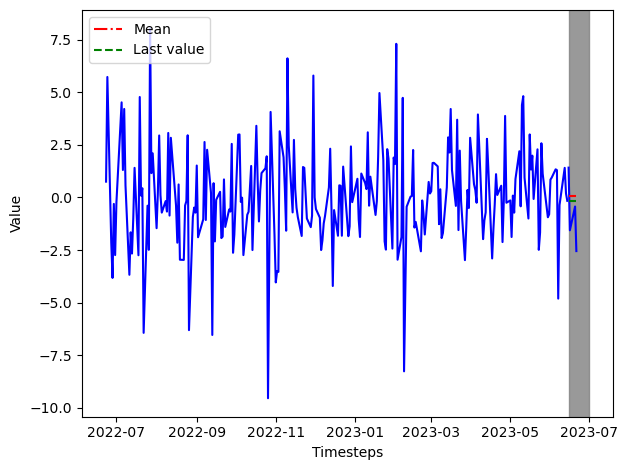

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train.iloc[0:], 'b-')
ax.plot(test['Close'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g--', label='Last value')
# ax.plot(rw_predictions[0], 'o--', label='Me')

ax.axvspan("2023-06-15", "2023-07", color='#808080', alpha=0.8)
# position the legend
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
# plt.xlim(200, 251)

plt.tight_layout()

In [43]:
test['Close']

Date
2023-06-15    1.419998
2023-06-16   -1.559998
2023-06-20   -0.430000
2023-06-21   -2.549995
Name: Close, dtype: float64

In [44]:
stc = test['Close'][:-1]
stc

Date
2023-06-15    1.419998
2023-06-16   -1.559998
2023-06-20   -0.430000
Name: Close, dtype: float64

In [45]:
stpl = test['pred_last'][:-1]
stpl

Date
2023-06-15   -0.160004
2023-06-16   -0.160004
2023-06-20   -0.160004
Name: pred_last, dtype: float64

In [46]:
# Get evaluation metrics
EvaluationMetric.eval_mse(test['Close'], test['pred_mean'], per_element=False)
EvaluationMetric.eval_mse(test['Close'], test['pred_last'], per_element=False)

EvaluationMetric.eval_mse(stc, stpl, per_element=False)
EvaluationMetric.eval_mse(stc, rw_predictions[3], per_element=False)


print()

EvaluationMetric.eval_rmse(test['Close'], test['pred_mean'], per_element=False)
EvaluationMetric.eval_rmse(test['Close'], test['pred_last'], per_element=False)

Test MSE: 2.864
Test MSE: 2.560
Test MSE: 1.510
Test MSE: 2.029

Test RMSE: 1.692
Test RMSE: 1.600
